# This script generates a video of general hive visualisation

## Imports

In [16]:
import multiprocessing, cv2, os, sys
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
sys.path.append(os.path.abspath('ABCThermalPlots'))
sys.path.append(os.path.abspath('ABCImaging'))
from libvisu import *
from ABCImaging.libimage import fetchImagesPaths
from ABCImaging.VideoManagment.videolib import generateVideoFromList
from InfluxDBInterface.libdb import download_data_DB
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)  # Set a wide width for display
pd.set_option('display.colheader_justify', 'center')  # Align column headers
from dask.distributed import Client
# Start a client using all CPUs of this machine
client = Client()
client

/opt/anaconda3/envs/imaging/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 64861 instead
  warnings.warn(
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:64862
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:64861/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:64865'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:64867'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:64869'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:64871'
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:64877 name: 3
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:64877
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:64885
INF

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:64861/status,
Dashboard: http://127.0.0.1:64861/status,Workers: 4
Total threads: 12,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:64862,Workers: 0
Dashboard: http://127.0.0.1:64861/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:64876,Total threads: 3
Dashboard: http://127.0.0.1:64878/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:64865,


## Configuration

In [17]:
# ==== GENERAL SETTINGS ====
download_data = True    # Set to True to download data from InfluxDB, False to use data stored locally
hive_nb = 1             # Hive number to process (1 or 2 for OH, 3 for BH and 0 for debugging)
t_res = "5min"          # Image time resolution. Change only if images are not taken every minute. Use frame_drop to keep only some frames, not this.
rootpath_imgs = '/Users/cyrilmonette/Library/CloudStorage/SynologyDrive-data/tmp/Images/'     # For images
first_dt = pd.to_datetime("251027-001000Z", format='%y%m%d-%H%M%S%z')
last_dt = pd.to_datetime("251028-163000Z", format='%y%m%d-%H%M%S%z')
frame_drop = 2          # We keep 1 frame every frame_drop frames. Put one to keep all frames.
verbose = True          # Set to True to print progress messages

# ==== LOCAL DATA CONFIGURATION ====
if not download_data:
    data_path = 'data/2025-10-06_13-18_influxdb_data.csv' # Path to the local .csv or .dat file containing the CO2, htr and tmp data

# ==== DATA DOWNLOAD CONFIGURATION ====
if download_data:
    bucket = 'ObsHiveABC' # InfluxDB bucket to download data from

## Main code

### Image fetching

In [18]:
# Get the target dt (for which we need an image, data, etc.)
datetimes = pd.date_range(start=first_dt, end=last_dt, freq=t_res)
datetimes = datetimes[::frame_drop]

imgs_paths = fetchImagesPaths(rootpath_imgs, datetimes, hive_nb)
print(f"Found {len(imgs_paths)} images for hive {hive_nb} between {first_dt} and {last_dt}.")

Found 243 images for hive 1 between 2025-10-27 00:10:00+00:00 and 2025-10-28 16:30:00+00:00.


### Htr, co2 and tmp data fetching

In [19]:
if download_data:
    data_res = int(t_res[0]) * 60
    filters = {'hive_num': str(hive_nb),
               'measurement': ['co2', 'htr', 'tmp']}
    hive_data = download_data_DB(bucket, first_dt, last_dt, data_res, filters, verbose=verbose) # Restricted to our time frame and hive
else:
    data_path = os.path.abspath(data_path)          # Absolute path to the data
    hive_data = extractData(data_path, hive_nb, datetimes, verbose=False) # Restricted to our time frame and hive
print(hive_data.head())

Executing query:

    from(bucket: "ObsHiveABC")
      |> range(start: 2025-10-27T00:05:00Z, stop: 2025-10-28T16:30:00Z)
      |> filter(fn: (r) => r["_measurement"] == "co2" or r["_measurement"] == "htr" or r["_measurement"] == "tmp")
      |> filter(fn: (r) => r["hive_num"] == "1")
      |> aggregateWindow(every: 300s, fn: last, createEmpty: false)
      |> yield(name: "last")
    
                                    _start                    _stop              _value     _field   _measurement board_id geo_loc hive_num inhive_loc          mcu_uuid          phys_loc  rpi_num   serial_id    valid actuator_instance
_time                                                                                                                                                                                                                                     
2025-10-27 00:10:00+00:00 2025-10-27 00:05:00+00:00 2025-10-28 16:30:00+00:00  774.923600        co2      co2       abc02    EPFL      1       

### tmp fetching

In [20]:
upper, lower = generateThermalDF(hive_data)   # Only tmp data, in a format that can be used by ThermalFrame

# Seek the max and min values of the tmp data, in both upper and lower hives
# max_temp = max(upper.max().max(), lower.max().max())
# min_temp = min(upper.min().min(), lower.min().min())

max_temp = np.nanmax([upper.to_numpy(), lower.to_numpy()])
min_temp = np.nanmin([upper.to_numpy(), lower.to_numpy()])
print("Max temperature in the selected time range: ", max_temp)
print("Min temperature in the selected time range: ", min_temp)
print(lower)

Max temperature in the selected time range:  37.8984375
Min temperature in the selected time range:  12.9296875
                              t00        t01        t02        t03        t04        t05        t06        t07        t08        t09        t10        t11        t12        t13        t14        t15        t16        t17        t18        t19        t20        t21     t22     t23        t24        t25        t26        t27        t28        t29        t30        t31        t32        t33        t34        t35        t36        t37        t38        t39        t40        t41        t42        t43        t44        t45        t46        t47        t48        t49        t50        t51        t52        t53        t54        t55        t56        t57        t58        t59     t60  t61  t62  t63
_time                                                                                                                                                                                       

### Metabolic data fetching

In [21]:
# Now we fetch the metabolic data
co2_data =generateMetabolicDF(hive_data)
print(co2_data)

                           ul    ur    ll    lr  
_time                                            
2025-10-27 00:10:00+00:00 NaN   495.0 NaN   677.0
2025-10-27 00:15:00+00:00 NaN   544.0 NaN   563.0
2025-10-27 00:20:00+00:00 NaN   506.0 NaN   516.0
2025-10-27 00:25:00+00:00 NaN   486.0 NaN   555.0
2025-10-27 00:30:00+00:00 NaN   478.0 NaN   484.0
...                        ..     ...  ..     ...
2025-10-28 16:10:00+00:00 NaN  4281.0 NaN  1800.0
2025-10-28 16:15:00+00:00 NaN  4810.0 NaN   979.0
2025-10-28 16:20:00+00:00 NaN  4211.0 NaN   858.0
2025-10-28 16:25:00+00:00 NaN  3155.0 NaN   634.0
2025-10-28 16:30:00+00:00 NaN  3664.0 NaN  1038.0

[485 rows x 4 columns]


### htr fetching

In [22]:
# Alternative used now:
upper_htr = hive_data[(hive_data["inhive_loc"] == "upper") & (hive_data["_measurement"] == "htr")]
lower_htr = hive_data[(hive_data["inhive_loc"] == "lower") & (hive_data["_measurement"] == "htr")]
# Drop the _measurement column
upper_htr = upper_htr.drop(columns=["_measurement"])
lower_htr = lower_htr.drop(columns=["_measurement"])
print(upper_htr) # TODO: it is missing columns. Check why, and how we can avoid it from breaking the automation part at the bottom of the nb !!
print(lower_htr)

Empty DataFrame
Columns: [_start, _stop, _value, _field, board_id, geo_loc, hive_num, inhive_loc, mcu_uuid, phys_loc, rpi_num, serial_id, valid, actuator_instance]
Index: []
                                    _start                    _stop             _value    _field   board_id geo_loc hive_num inhive_loc          mcu_uuid          phys_loc  rpi_num   serial_id    valid actuator_instance
_time                                                                                                                                                                                                                      
2025-10-27 00:10:00+00:00 2025-10-27 00:05:00+00:00 2025-10-28 16:30:00+00:00  15.27344   avg_temp   abc02    EPFL      1       lower    2191218169584597824190002   bass       1     /dev/ttyACM1  True          h00      
2025-10-27 00:10:00+00:00 2025-10-27 00:05:00+00:00 2025-10-28 16:30:00+00:00   0.00000  is_active   abc02    EPFL      1       lower    2191218169584597824190002   b

### Plotting

<Figure size 1800x1200 with 0 Axes>

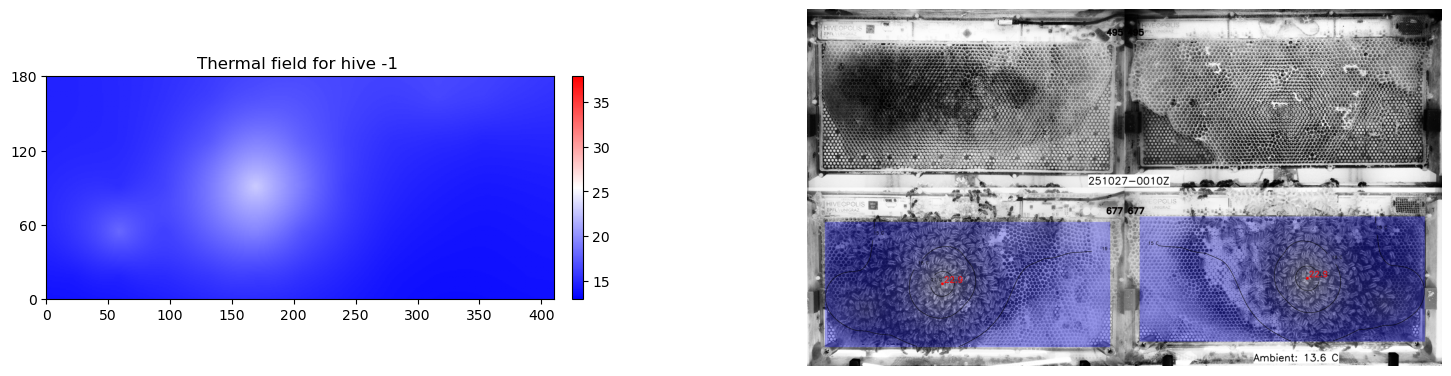

In [23]:
vmax = max_temp
vmin = min_temp
# For a random time frame, generate the image of the hive and the thermal plot side by side with matplotlib
# This is just to check that everything is working fine
plt.figure(figsize=(18, 12))
frame = 0 # Frame idx within datetimes
dt = datetimes[frame]
_imgs_paths = imgs_paths.loc[dt].to_numpy()
imgs_names = [str(_imgs_paths[i]).split("/")[-1][:-4] for i in range(len(_imgs_paths))]
# Read the images using cv2
current_imgs = [cv2.imread(_imgs_paths[i], cv2.IMREAD_GRAYSCALE) if _imgs_paths[i] is not None else np.zeros((2592,4608), np.uint8) for i in range(len(_imgs_paths))]

# Thermal data
try:
    upper_tf = ThermalFrame(upper.loc[dt].to_numpy())
except NoValidSensors:
    upper_tf = None

try:
    lower_tf = ThermalFrame(lower.loc[dt].to_numpy())
except NoValidSensors:
    lower_tf = None

fig, ax = plt.subplots(1, 2, figsize=(18, 12))
lower_tf.calculate_thermal_field()
lower_tf.plot_thermal_field(ax=ax[0], v_min=vmin, v_max=vmax)

# Metabolic data
if dt in co2_data.index:
    metabolic_df = co2_data.loc[dt]
else:
    metabolic_df = None

# Lower heater
if dt in lower_htr.index:
    lower_htr_row = lower_htr.loc[dt]
else:
    lower_htr_row = None

# Upper heater
if dt in upper_htr.index:
    upper_htr_row = upper_htr.loc[dt]
else:
    upper_htr_row = None

hs_1 = Hive(dt, current_imgs, False, imgs_names, upper_tf, lower_tf, metabolic_df, upper_htr_row, lower_htr_row, hive_nb=hive_nb)
contours = list(range(12, 37, 3))
snapshot = hs_1.snapshot(v_max=vmax, v_min=vmin, contours=contours, annotate_contours=True, annotate_names=False, thermal_transparency=0.35)
plt.imshow(snapshot)
plt.axis('off') 
plt.show()

### Automation

In [24]:
final_imgs = []
print("Generating frames...")
for dt in tqdm(datetimes):
    _imgs_paths = imgs_paths.loc[dt].to_numpy()
    imgs_names = [str(_imgs_paths[j]).split("/")[-1][:-4] for j in range(len(_imgs_paths))]
    # Read the images using cv2
    current_imgs = []
    for _img_path in _imgs_paths:
        if _img_path is not None:
            img = cv2.imread(_img_path, cv2.IMREAD_GRAYSCALE)
            current_imgs.append(img)
        else:
            current_imgs.append(np.zeros((2592,4608), np.uint8))
        
    # Thermal data
    try:
        upper_tf = ThermalFrame(upper.loc[dt].to_numpy())
    except NoValidSensors:
        upper_tf = None
    
    try:
        lower_tf = ThermalFrame(lower.loc[dt].to_numpy())
    except NoValidSensors:
        lower_tf = None

    # Metabolic data
    if dt in co2_data.index:
        metabolic_df = co2_data.loc[dt]
    else:
        metabolic_df = None

    # Lower heater
    if dt in lower_htr.index:
        lower_htr_row = lower_htr.loc[dt]
    else:
        lower_htr_row = None

    # Upper heater
    if dt in upper_htr.index:
        upper_htr_row = upper_htr.loc[dt]
    else:
        upper_htr_row = None

    hs = Hive(dt, current_imgs, False, imgs_names, upper_tf, lower_tf, metabolic_df, upper_htr_row, lower_htr_row, hive_nb=hive_nb)

    snapshot = hs.snapshot(v_max=max_temp, v_min=min_temp,contours=contours,annotate_contours=True, thermal_transparency=0.4)
    final_imgs.append(snapshot)

# Change frames from rgb to bgr
print("Convert frames to bgr...")
for i in tqdm(range(len(final_imgs))):
    final_imgs[i] = cv2.cvtColor(final_imgs[i], cv2.COLOR_RGB2BGR)

dest = "outputVideos/"
# Make this a global path
print("Saving video...")
generateVideoFromList(final_imgs, dest="outputVideos/", name=f"hive{hive_nb}_{first_dt.strftime('%y%m%d-%H%M%Z')}_{last_dt.strftime('%y%m%d-%H%M%Z')}", fps=10, grayscale=False)

# Cleanup step to release resources
multiprocessing.active_children()

Generating frames...


100%|██████████| 243/243 [02:31<00:00,  1.60it/s]


Convert frames to bgr...


100%|██████████| 243/243 [00:02<00:00, 102.09it/s]


Saving video...


Writing video: 100%|██████████| 243/243 [00:21<00:00, 11.27frame/s]


[<SpawnProcess name='Dask Worker process (from Nanny)' pid=45079 parent=44505 started daemon>,
 <SpawnProcess name='Dask Worker process (from Nanny)' pid=45082 parent=44505 started daemon>,
 <SpawnProcess name='Dask Worker process (from Nanny)' pid=45081 parent=44505 started daemon>,
 <SpawnProcess name='Dask Worker process (from Nanny)' pid=45080 parent=44505 started daemon>]